In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing

from tensorflow.keras import models, layers, utils

import urllib.request
import zipfile
import os

In [3]:
movielens_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
download_path = "/content/movielens"

os.makedirs(download_path, exist_ok=True)
zip_file_path = os.path.join(download_path, "ml-latest-small.zip")
urllib.request.urlretrieve(movielens_url, zip_file_path)

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  zip_ref.extractall(download_path)

extracted_files = os.listdir(download_path)
print("Files in the extracted directory:", extracted_files)

Files in the extracted directory: ['ml-latest-small.zip', 'ml-latest-small']


In [4]:
dtf_products = pd.read_csv("movielens/ml-latest-small/movies.csv")
dtf_products = dtf_products.dropna(subset=["genres"])

# Extract release date using regular expression
dtf_products["date"] = dtf_products["title"].str.extract(r"\((\d{4})\)", expand=False)
dtf_products["date"] = pd.to_numeric(dtf_products["date"], errors="coerce")
dtf_products["date"] = dtf_products["date"].fillna(9999)

# Create a new column "old" based on the release date
dtf_products["old"] = dtf_products["date"].apply(lambda x: 1 if x < 2000 else 0)

# Additional columns if needed
dtf_products["product"] = range(len(dtf_products))
dtf_products["name"] = dtf_products["title"].str.replace(r"[\(\[].*?[\)\]]", "").str.strip()

dtf_products


,movieId,title,genres,date,old,product,name
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,1,0,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,1,1,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,1,2,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,1,3,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995.0,1,4,Father of the Bride Part II
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017.0,0,9737,Black Butler: Book of the Atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017.0,0,9738,No Game No Life: Zero
9739,193585,Flint (2017),Drama,2017.0,0,9739,Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018.0,0,9740,Bungo Stray Dogs: Dead Apple


In [5]:
dtf_users = pd.read_csv("movielens/ml-latest-small/ratings.csv")
dtf_users["user"] = dtf_users["userId"].apply(lambda x: x - 1)
dtf_users["timestamp"] = pd.to_datetime(dtf_users["timestamp"], unit='s')
dtf_users = dtf_users.rename(columns={"rating": "y"})

# Create daytime and weekend features
dtf_users["daytime"] = dtf_users["timestamp"].apply(lambda x: 1 if 6 < x.hour < 20 else 0)
dtf_users["weekend"] = dtf_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5, 6] else 0)

# Merge with dtf_products to get the "product" column
dtf_users = dtf_users.merge(dtf_products[["movieId", "product"]], how="left")

dtf_users

,userId,movieId,y,timestamp,user,daytime,weekend,product
0,1,1,4.0,2000-07-30 18:45:03,0,1,1,0
1,1,3,4.0,2000-07-30 18:20:47,0,1,1,2
2,1,6,4.0,2000-07-30 18:37:04,0,1,1,5
3,1,47,5.0,2000-07-30 19:03:35,0,1,1,43
4,1,50,5.0,2000-07-30 18:48:51,0,1,1,46
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,609,0,0,9434
100832,610,168248,5.0,2017-05-03 22:21:31,609,0,0,9461
100833,610,168250,5.0,2017-05-08 19:50:47,609,1,0,9462
100834,610,168252,5.0,2017-05-03 21:19:12,609,0,0,9463


In [6]:
dtf_products = dtf_products.set_index("product").loc[:, ["name", "old", "genres"]]
dtf_products.head()

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


In [7]:
dtf_context = dtf_users.loc[:, ["user", "product", "daytime", "weekend"]]
dtf_context.head()

,user,product,daytime,weekend
0,0,0,1,1
1,0,2,1,1
2,0,5,1,1
3,0,43,1,1
4,0,46,1,1


In [8]:
dtf_users = dtf_users.loc[:, ["user", "product", "y"]]
dtf_users.head()

,user,product,y
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


In [9]:
columns = dtf_products["genres"].str.split("|", expand=True).stack().unique().tolist()
columns.remove('(no genres listed)')
print(columns)

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir']


In [10]:
for col in columns:
    dtf_products[col] = dtf_products["genres"].apply(lambda x: 1 if col in x else 0)
dtf_products.head()

,name,old,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,1,Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,1,Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,1,Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


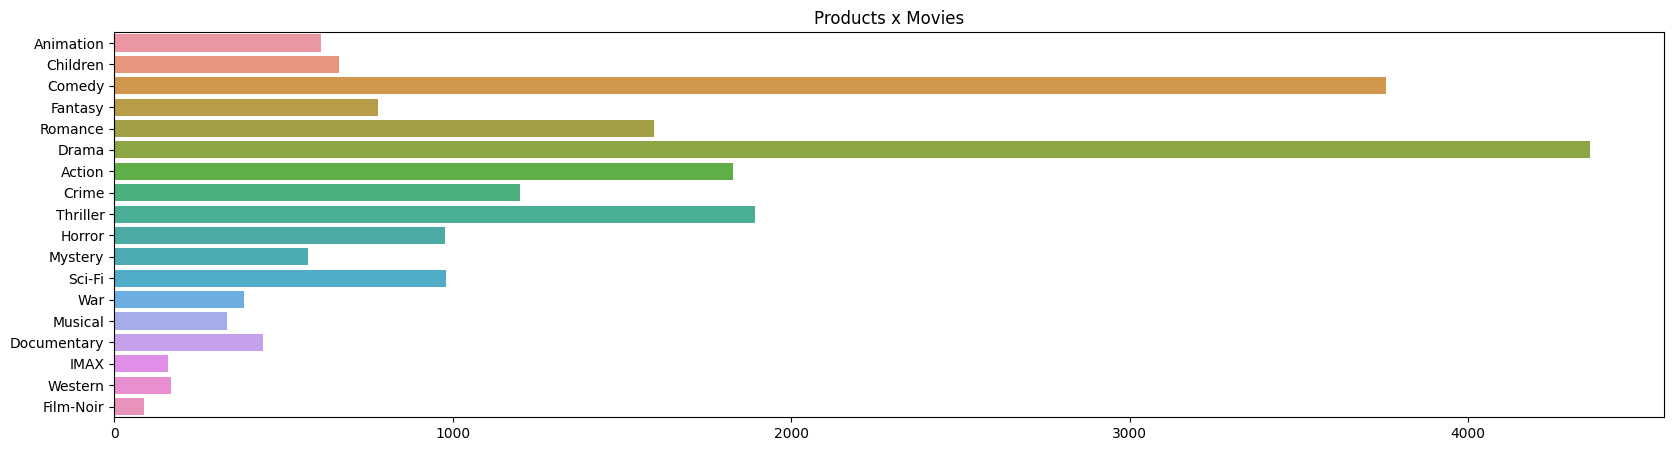

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
genre_counts = dtf_products.iloc[:, 4:].sum()
sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=ax)
ax.set_title("Products x Movies")
plt.show()

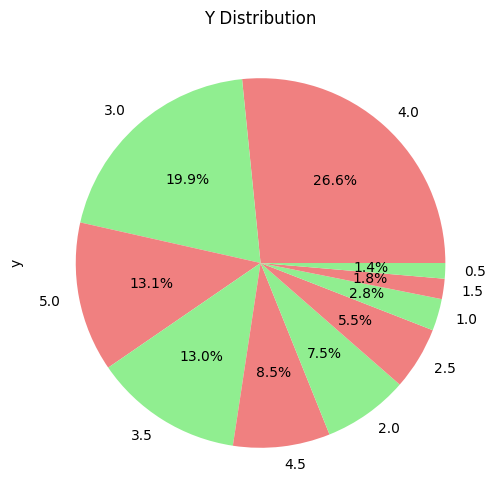

In [12]:
plt.figure(figsize=(10, 6))
dtf_users["y"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["lightcoral", "lightgreen"])
plt.title("Y Distribution")
plt.show()

In [13]:
dtf_users = dtf_users.pivot_table(index="user", columns="product", values="y").reindex(columns=dtf_products.index, fill_value=np.nan)
dtf_users

product,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


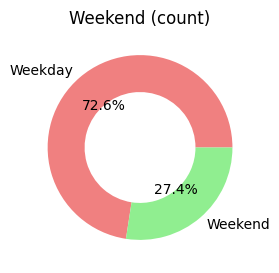

In [14]:
plt.figure(figsize=(5, 3))
plt.pie(dtf_context["weekend"].value_counts(), labels=["Weekday", "Weekend"], autopct="%1.1f%%", colors=["lightcoral", "lightgreen"], wedgeprops=dict(width=0.4))
plt.title("Weekend (count)")
plt.show()

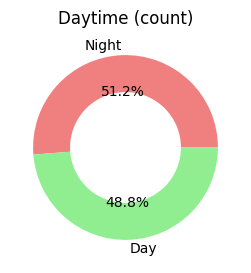

In [15]:
plt.figure(figsize=(5, 3))
plt.pie(dtf_context["daytime"].value_counts(), labels=["Night", "Day"], autopct="%1.1f%%", colors=["lightcoral", "lightgreen"], wedgeprops=dict(width=0.4))
plt.title("Daytime (count)")
plt.show()

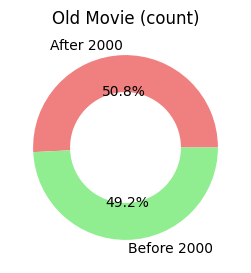

In [16]:
plt.figure(figsize=(5, 3))
plt.pie(dtf_products["old"].value_counts(), labels=["After 2000", "Before 2000"], autopct="%1.1f%%", colors=["lightcoral", "lightgreen"], wedgeprops=dict(width=0.4))
plt.title("Old Movie (count)")
plt.show()

In [17]:
dtf_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(dtf_users.values),
                         columns=dtf_users.columns, index=dtf_users.index)
print(dtf_users.shape)
dtf_users

(610, 9742)


product,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
split = int(0.8*dtf_users.shape[1])
split

7793

In [19]:
# Train
dtf_train = dtf_users.loc[:, :split-1]
print("non-null data:", dtf_train[dtf_train>0].count().sum())
dtf_train

non-null data: 94054


product,0,1,2,3,4,5,6,7,8,9,...,7783,7784,7785,7786,7787,7788,7789,7790,7791,7792
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Test
dtf_test = dtf_users.loc[:, split:]
print("non-null data:", dtf_test[dtf_test>0].count().sum())
dtf_test

non-null data: 6782


product,7793,7794,7795,7796,7797,7798,7799,7800,7801,7802,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Model 1

In [21]:
# Select a user
i = 1
train = dtf_train.iloc[i].to_frame(name="y")
test = dtf_test.iloc[i].to_frame(name="y")

print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
test.head()

train: 21 | test: 8


,y
product,
7793,NaN
7794,NaN
7795,NaN
7796,NaN
7797,NaN


In [22]:
# add all products in test but empty
tmp = test.copy()
tmp["y"] = np.nan
train = train.append(tmp)
train.head()

,y
product,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [23]:
# Model
usr = train[["y"]].fillna(0).values.T
prd = dtf_products.drop(["name","genres"],axis=1).values
print("Users", usr.shape, " x  Products", prd.shape)

Users (1, 9742)  x  Products (9742, 20)


In [24]:
usr_ft = np.dot(usr, prd)
weights = usr_ft / usr_ft.sum()
pred = np.dot(weights, prd.T)

test = test.merge(pd.DataFrame(pred[0], columns=["yhat"]), how="left", left_index=True, right_index=True).reset_index()
test = test[~test["y"].isna()]
test

,product,y,yhat
270,8063,0.812500,0.367409
512,8305,1.000000,0.446949
583,8376,0.777778,0.071390
673,8466,0.875000,0.211218
716,8509,0.500000,0.467547
757,8550,0.833333,0.348377
888,8681,1.000000,0.328201
1035,8828,0.500000,0.030355


In [25]:
# Evaluate
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for product in y_test:
        mrr = 1 / (list(predicted).index(product) + 1) if product in predicted else 0
        score.append(mrr)
    return np.mean(score)

In [26]:
print("--- user", i, "---")

top = 5
y_test = test.sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test.sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8509 8305 8063 8550 8681]
true positive: 4 (80.0%)
accuracy: 20.0%
mrr: 0.26


In [27]:
test.join(dtf_products[["name", "old", "genres"]], on="product").sort_values("yhat", ascending=False)

,product,y,yhat,name,old,genres
716,8509,0.500000,0.467547,The Drop,0,Crime|Drama|Thriller
512,8305,1.000000,0.446949,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
270,8063,0.812500,0.367409,Django Unchained,0,Action|Drama|Western
757,8550,0.833333,0.348377,Ex Machina,0,Drama|Sci-Fi|Thriller
888,8681,1.000000,0.328201,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
673,8466,0.875000,0.211218,Whiplash,0,Drama
583,8376,0.777778,0.071390,Interstellar,0,Sci-Fi|IMAX
1035,8828,0.500000,0.030355,The Jinx: The Life and Deaths of Robert Durst,0,Documentary


In [60]:
train_set = dtf_train.copy()
tmp = dtf_test.copy()
train_set = pd.concat([train_set, tmp], axis=1)
test_set = dtf_test.copy()

usr = train_set.fillna(0).values # users*movies
prd = dtf_products.drop(["name","genres"],axis=1).values #movies * features

usr_ft = np.dot(usr, prd) # users*features
weights = usr_ft / np.sum(usr_ft, axis=1).reshape((-1, 1))

test_pred = np.dot(weights, prd.T)[:, split:] #users * movies[split:]
print(test_pred.shape)

test_org = dtf_test.fillna(0).values
print(test_org.shape)

(610, 1949)
(610, 1949)


In [61]:
rmse = np.sqrt(np.mean((test_org - test_pred)**2))
print("Root Mean Squared Error for Model 1 :", rmse)

Root Mean Squared Error for Model 1 : 0.22361187818526385


## Model 2

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.875000
4,1,8509,0.500000


In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Users (,1,embedding_size) and Reshape (,embedding_size)
xusers_in = layers.Input(name="users_input", shape=(1,))
xusers_emb = layers.Embedding(name="users_embedding", input_dim=usr, output_dim=embeddings_size)(xusers_in)
xusers = layers.Reshape(name='users', target_shape=(embeddings_size,))(xusers_emb)

# Products (,1,embedding_size) and Reshape (,embedding_size)
xproducts_in = layers.Input(name="products_input", shape=(1,))
xproducts_emb = layers.Embedding(name="products_embedding", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
xproducts = layers.Reshape(name='products', target_shape=(embeddings_size,))(xproducts_emb)

# Product (,1) values[-1,1]
xx = layers.Dot(name='user_product', normalize=True, axes=1)([xusers, xproducts])

# Predict ratings (,1)
y_out = layers.Dense(name="out", units=1, activation='linear')(xx)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 users_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 products_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 users_embedding (Embedding  (None, 1, 50)                30500     ['users_input[0][0]']         
 )                                                                                                
                                                                             

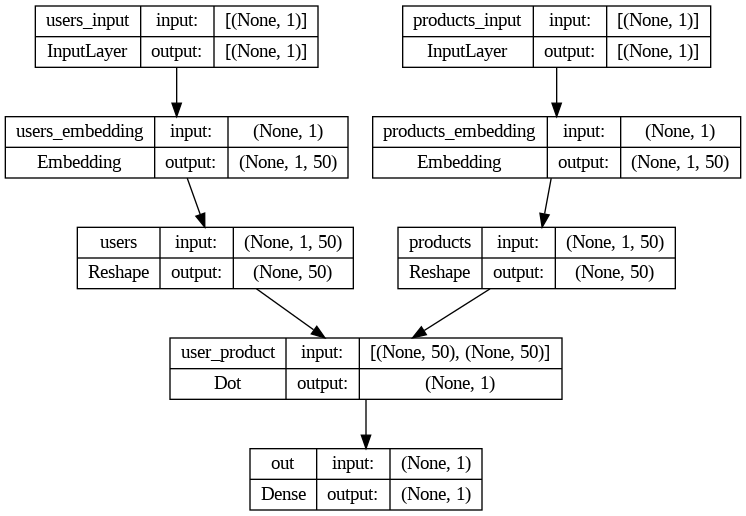

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    history = pd.DataFrame(training.history)
    metrics = [col for col in history.columns if ('loss' not in col) and ('val' not in col)]

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 3))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    history.plot(y=['loss'], ax=ax[0], color='black', legend=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    history.plot(y=metrics, ax=ax11)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    history.plot(y=['val_loss'], ax=ax[1], color='black', legend=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    history.plot(y=['val_' + metric for metric in metrics], ax=ax22)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

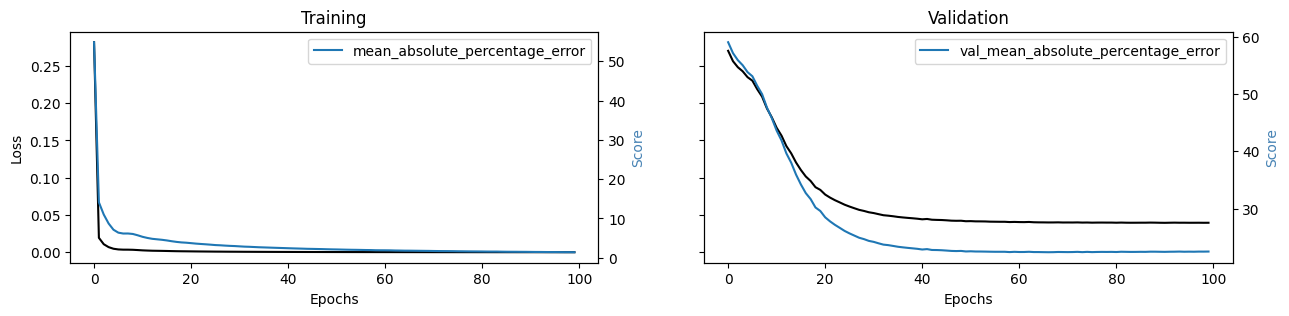

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

212/212 [==============================] - 0s 2ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.966838
1,1,8305,1.000000,0.806270
2,1,8376,0.777778,0.889365
3,1,8466,0.875000,0.702127
4,1,8509,0.500000,0.889242
...,...,...,...,...
6777,609,9434,0.937500,0.986054
6778,609,9461,1.000000,0.822355
6779,609,9462,1.000000,0.794090
6780,609,9463,1.000000,0.927422


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Root Mean Squared Error :",np.sqrt(np.mean((y_test-predicted)**2)))
print("Mean Absolute Perc Error:", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2)))

Root Mean Squared Error : 0.22525054290434302
Mean Absolute Perc Error: 0.25%


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8063 8681 8376 8509 8305]
true positive: 3 (60.0%)
accuracy: 20.0%
mrr: 0.34


In [ ]:
test[test["user"] == i].set_index("product").join(dtf_products[["name", "old", "genres"]]).sort_values("yhat", ascending=False)

,user,y,yhat,name,old,genres
product,,,,,,
8063,1,0.812500,0.966838,Django Unchained,0,Action|Drama|Western
8681,1,1.000000,0.958620,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
8376,1,0.777778,0.889365,Interstellar,0,Sci-Fi|IMAX
8509,1,0.500000,0.889242,The Drop,0,Crime|Drama|Thriller
8305,1,1.000000,0.806270,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
8550,1,0.833333,0.775283,Ex Machina,0,Drama|Sci-Fi|Thriller
8828,1,0.500000,0.736177,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
8466,1,0.875000,0.702127,Whiplash,0,Drama


## Model 3

In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
train.head()

,user,product,y
0,0,0,0.888889
1,0,2,0.888889
2,0,5,0.875000
3,0,43,1.000000
4,0,46,1.000000


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})
test.head()

,user,product,y
0,1,8063,0.812500
1,1,8305,1.000000
2,1,8376,0.777778
3,1,8466,0.875000
4,1,8509,0.500000


In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="users_input", shape=(1,))
xproducts_in = layers.Input(name="products_input", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_users_embedding", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_users', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_products_embeddings", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_products', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_users_products', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_users_embedding", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_users', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_products_embedding", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_products', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_users_products", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 users_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 products_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 nn_users_embedding (Embedd  (None, 1, 50)                30500     ['users_input[0][0]']         
 ing)                                                                                             
                                                                      

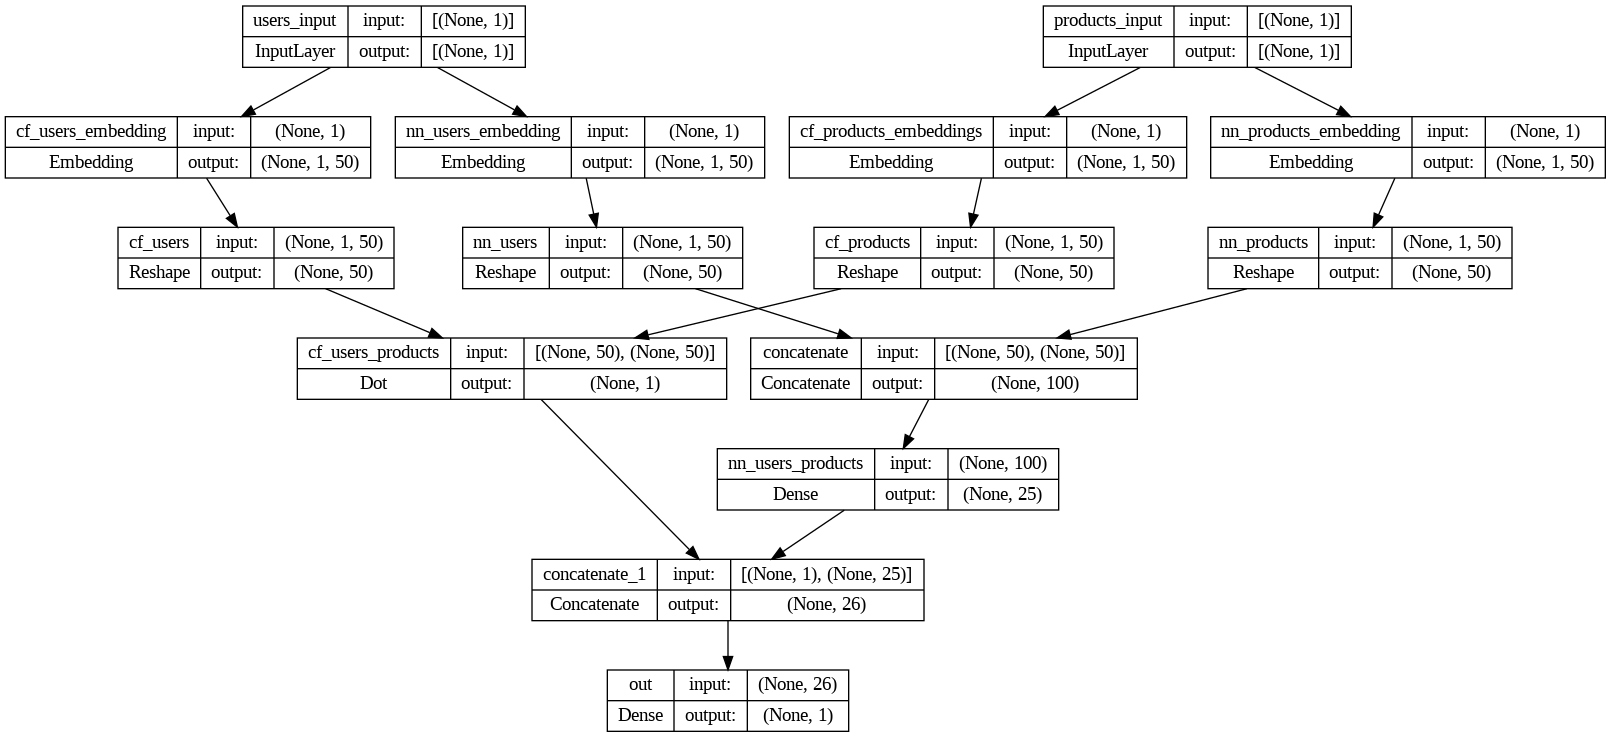

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


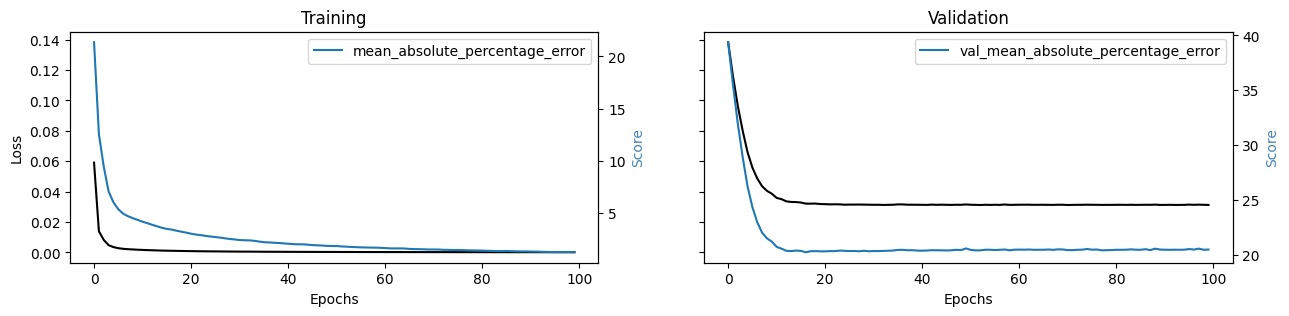

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

212/212 [==============================] - 0s 2ms/step


,user,product,y,yhat
0,1,8063,0.812500,0.844404
1,1,8305,1.000000,0.766967
2,1,8376,0.777778,0.777539
3,1,8466,0.875000,0.792875
4,1,8509,0.500000,0.825778
...,...,...,...,...
6777,609,9434,0.937500,0.780653
6778,609,9461,1.000000,0.755236
6779,609,9462,1.000000,0.776001
6780,609,9463,1.000000,0.815065


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]


print("Root Mean Squared Error:",np.sqrt(np.mean((y_test-predicted)**2)))
print("Mean Absolute Perc Error:", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2)))

Root Mean Squared Error: 0.20959975838195405
Mean Absolute Perc Error: 0.23


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8828 8063 8509 8681 8466]
true positive: 3 (60.0%)
accuracy: 0.0%
mrr: 0.19


In [ ]:
test[test["user"]==i].merge(
        dtf_products[["name","old","genres"]], left_on="product", right_index=True
    ).sort_values("yhat", ascending=False)

,user,product,y,yhat,name,old,genres
7,1,8828,0.500000,0.897218,The Jinx: The Life and Deaths of Robert Durst,0,Documentary
0,1,8063,0.812500,0.844404,Django Unchained,0,Action|Drama|Western
4,1,8509,0.500000,0.825778,The Drop,0,Crime|Drama|Thriller
6,1,8681,1.000000,0.793927,Mad Max: Fury Road,0,Action|Adventure|Sci-Fi|Thriller
3,1,8466,0.875000,0.792875,Whiplash,0,Drama
2,1,8376,0.777778,0.777539,Interstellar,0,Sci-Fi|IMAX
1,1,8305,1.000000,0.766967,"Wolf of Wall Street, The",0,Comedy|Crime|Drama
5,1,8550,0.833333,0.684013,Ex Machina,0,Drama|Sci-Fi|Thriller


##Model 3

In [ ]:
# Extra data
features = dtf_products.drop(["genres","name"], axis=1).columns
print(features)

context = dtf_context.drop(["user","product"], axis=1).columns
print(context)

Index(['old', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery',
       'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western',
       'Film-Noir'],
      dtype='object')
Index(['daytime', 'weekend'], dtype='object')


In [ ]:
train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
train = train.merge(dtf_products[features], how="left", left_on="product", right_index=True)

## add context
train = train.merge(dtf_context, how="left")

train.head()

,user,product,y,old,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,daytime,weekend
0,0,0,0.888889,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,1,1
1,0,2,0.888889,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
2,0,5,0.875000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,43,1.000000,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,0,46,1.000000,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1


In [ ]:
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

## add features
test = test.merge(dtf_products.drop(["genres","name"], axis=1), how="left", left_on="product", right_index=True)

## add context
test = test.merge(dtf_context, how="left")

test.head()

,user,product,y,old,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,daytime,weekend
0,1,8063,0.812500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
1,1,8305,1.000000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,8376,0.777778,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,1
3,1,8466,0.875000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1,8509,0.500000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="users_input", shape=(1,))
xproducts_in = layers.Input(name="products_input", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_users_embedding", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_users', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_products_embedding", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_products', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_users_products', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_users_embedding", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_users', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_products_embedding", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_products', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_users_products", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_input", shape=(feat,))
features_x = layers.Dense(name="features", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_input", shape=(ctx,))
context_x = layers.Dense(name="context", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 users_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 products_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 nn_users_embedding (Embedd  (None, 1, 50)                30500     ['users_input[0][0]']         
 ing)                                                                                             
                                                                                       

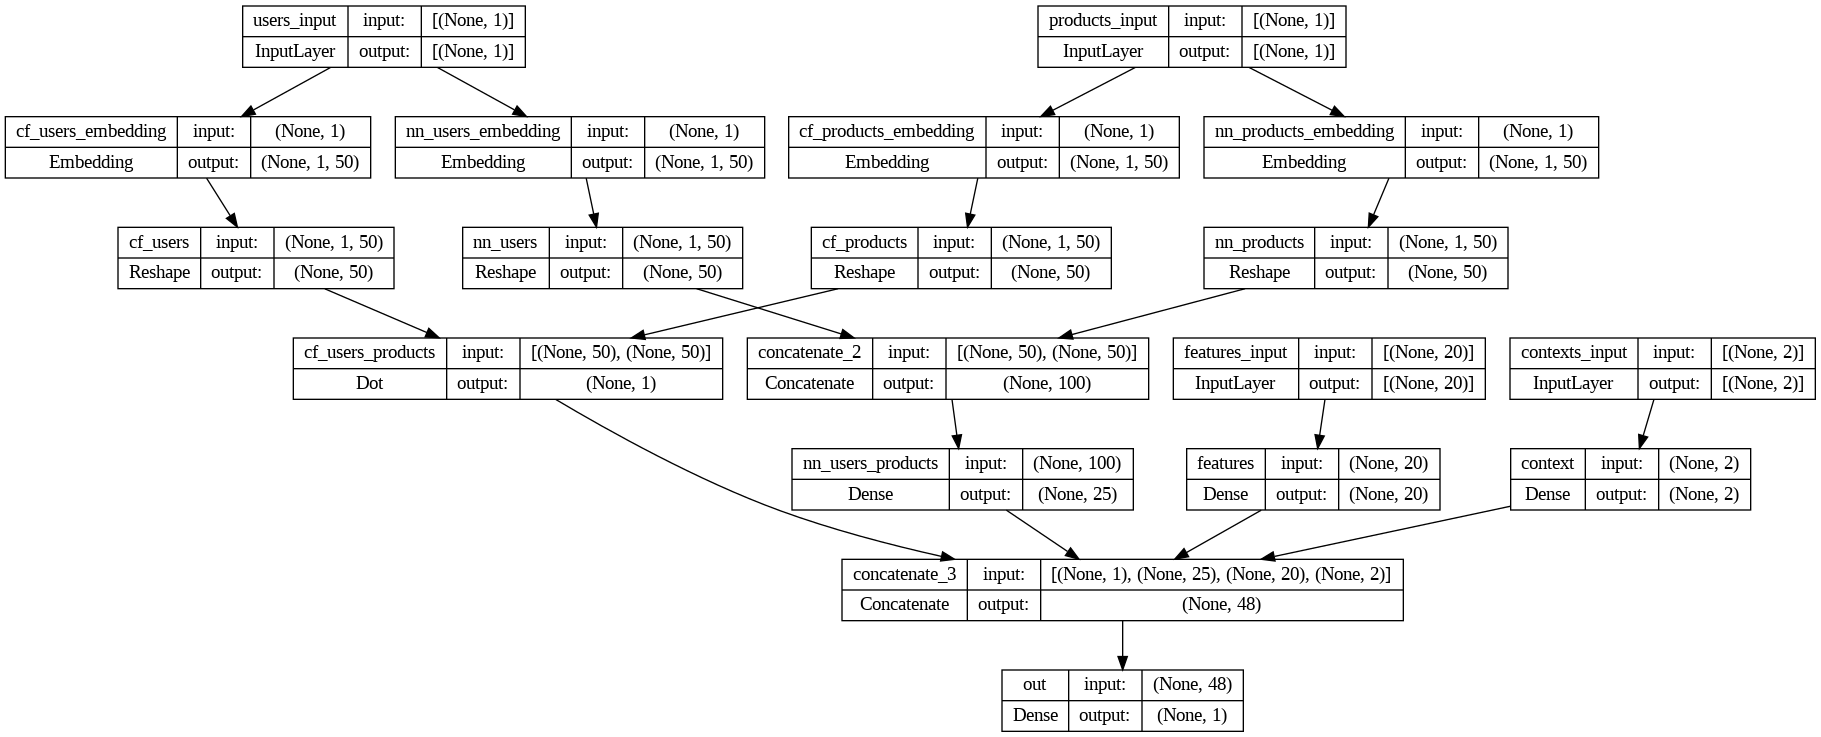

In [ ]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

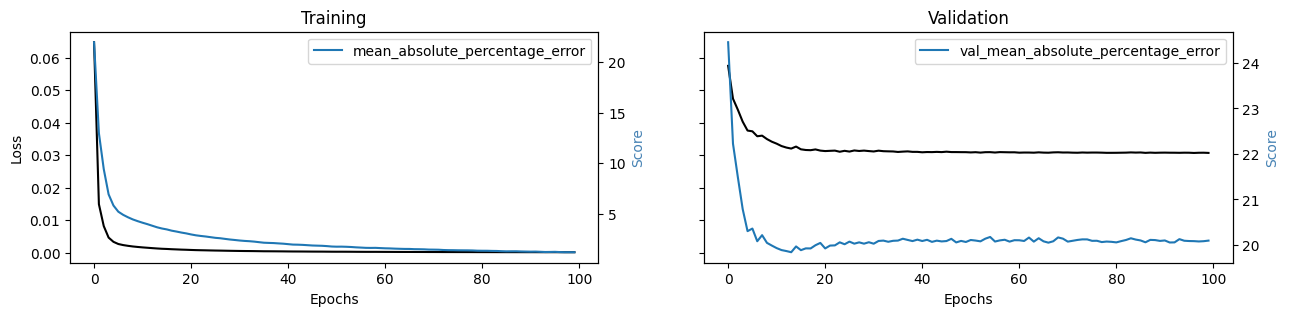

In [ ]:
model = training.model
utils_plot_keras_training(training)

In [ ]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

212/212 [==============================] - 1s 2ms/step


,user,product,y,old,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,daytime,weekend,yhat
0,1,8063,0.812500,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0.875056
1,1,8305,1.000000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0.735762
2,1,8376,0.777778,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,1,0.843643
3,1,8466,0.875000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.841924
4,1,8509,0.500000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0.640523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6777,609,9434,0.937500,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.829026
6778,609,9461,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.768698
6779,609,9462,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.765272
6780,609,9463,1.000000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0.734565


In [ ]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Root Mean Squared Error:", np.sqrt(np.mean((y_test-predicted)**2)))
print("Mean Absolute Perc Error:", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2)))

Root Mean Squared Error: 0.20476144177500152
Mean Absolute Perc Error: 0.23


In [ ]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user"]==i].sort_values("y", ascending=False)["product"].values[:top]
print("y_test:", y_test)

predicted = test[test["user"]==i].sort_values("yhat", ascending=False)["product"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "("+str(round(true_positive/top*100,1))+"%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test,predicted)*100,1))+"%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted),2))

--- user 1 ---
y_test: [8305 8681 8466 8550 8063]
predicted: [8063 8681 8376 8466 8550]
true positive: 4 (80.0%)
accuracy: 20.0%
mrr: 0.39
